In [146]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython import display
from collections import Counter
import optuna
import wandb
from tqdm import tqdm
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

In [68]:
# Environment setup
env = gym.make('FrozenLake-v1', is_slippery=False)
n_actions = env.action_space.n
n_states = env.observation_space.n

In [91]:
# Neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(n_states, n_actions)

    def forward(self, x):
        return self.fc(x)
    
class ConvNet(nn.Module):
    def __init__(self, input_size, n_actions):
        super(ConvNet, self).__init__()
        # Assuming input_size is the flattened size of the 2D state
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # Flatten the output for the fully connected layer
        self.fc = nn.Linear(32 * input_size, n_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(1, -1)  # Flatten
        return self.fc(x)

In [92]:
device = torch.device("mps")

In [93]:
def preprocess_state(position, map_layout):
    nrows, ncols = 4, 4  # Assuming a 4x4 map
    state_matrix = np.zeros((nrows, ncols))
    
    # Decode map layout
    layout_to_val = {b'F': 0, b'H': 1, b'S': 0, b'G': 3}  # Start 'S' also considered safe '0'
    for i in range(nrows):
        for j in range(ncols):
            state_matrix[i][j] = layout_to_val[map_layout[i][j]]

    # Convert position to 2D coordinates and update in state matrix
    row, col = divmod(position, ncols)
    state_matrix[row][col] = 2  # Marking the current position

    # Normalize
    normalized_state = state_matrix / 3.0 - 0.5
    return torch.tensor(normalized_state, dtype=torch.float).unsqueeze(0)  # Adds batch dimension


In [ ]:
# Training Function
def train_model(model, optimizer, loss_fn, gamma, epsilon_start, epsilon_decay, num_episodes, device, n_states, random_map=False, is_slippery=False):
    epsilon = epsilon_start

    # Training loop
    # Initialize lists to store metrics
    losses = []
    weight_norms = []
    bias_norms = []
    grad_norms = []
    total_rewards = []
    epsilon_values = []
    episode_lengths = []
    successful_episodes = 0
    success_rate = []

    plot_update_frequency = int(num_episodes * (5/100))  # update plots every 5% of episodes


    # Training loop
    for episode in tqdm(range(num_episodes)):
        if random_map:
            env = gym.make('FrozenLake-v1', desc=generate_random_map(size=4), is_slippery=is_slippery)
        else:
            env = gym.make('FrozenLake-v1', is_slippery=is_slippery)

        state = env.reset()[0]
        done = False
        episode_length = 0
        total_reward = 0

        # Calculate max steps as a factor of the environment size
        max_steps = len(env.desc) * len(env.desc[0]) * 4 # 4x the number of states seems like a reasonable upper bound
        step_count = 0

        while not done and step_count < max_steps:
            step_count += 1
            #state_tensor = torch.FloatTensor(np.eye(n_states)[int(state)]).to(device)
            state_tensor = preprocess_state(state, env.desc).to(device)
            q_values = model(state_tensor)[0] # Remove batch dimension
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = torch.argmax(q_values).item()

            # (0, 0.0, False, False, {'prob': 1.0})
            next_state, reward, done, _, _ = env.step(action)

            #next_state_tensor = torch.FloatTensor(np.eye(n_states)[next_state]).to(device)
            next_state_tensor = preprocess_state(next_state, env.desc).to(device)
            next_q_values = model(next_state_tensor)[0] # Remove batch dimension

            max_next_q = torch.max(next_q_values)
            q_target = reward + gamma * max_next_q * (1 - done)
            q_val = q_values[action]

            loss = loss_fn(q_val.view(1).cpu(), torch.tensor([q_target]))

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            optimizer.step()

            state = next_state

            # Calculate and store loss
            losses.append(loss.item())

            # Calculate and store weight and bias norms
            weight_norm = sum(torch.norm(param)**2 for param in model.parameters() if param.dim() > 1)
            bias_norm = sum(torch.norm(param)**2 for param in model.parameters() if param.dim() == 1)
            weight_norms.append(weight_norm.item())
            bias_norms.append(bias_norm.item())

            # Calculate and store gradient norms
            grad_norm = sum(torch.norm(param.grad)**2 for param in model.parameters() if param.grad is not None)
            grad_norms.append(grad_norm.item())

            # Accumulate reward
            total_reward += reward
            # Increment episode length
            episode_length += 1

            if done and reward > 0:  # Assuming a positive reward indicates success
                successful_episodes += 1

        # Store total reward and epsilon value for the episode
        total_rewards.append(total_reward)
        epsilon_values.append(epsilon)
        episode_lengths.append(episode_length)
        success_rate.append(successful_episodes / (episode + 1))  # Calculate success rate

        # Decay epsilon
        if epsilon > 0.01:
            epsilon *= epsilon_decay

        # Update plots at specified frequency
        if episode % plot_update_frequency == 0 or episode == num_episodes - 1:
            # log metrics to wandb  
            wandb.log({"loss": loss.item(),
                       "weight_norm": weight_norm.item(),
                       "bias_norm": bias_norm.item(),
                       "grad_norm": grad_norm.item(),
                       f"total_reward_previous_{plot_update_frequency}_episodes": sum(total_rewards[-plot_update_frequency:-1]),
                       "epsilon": epsilon,
                       "episode_length": episode_length,
                       "success_rate": success_rate[-1],
                       "learning_rate": learning_rate})
                
        # Close the environment at the end of the episode
        env.close()



    return model

In [136]:
# Evaluation Function
def evaluate_model(model, num_eval_episodes, device, n_states, is_slippery=False, random_map=False):
    successful_episodes = 0
    
    for _ in tqdm(range(num_eval_episodes)):
        if random_map:
            env = gym.make('FrozenLake-v1', desc=generate_random_map(size=4), is_slippery=is_slippery)
        else:
            env = gym.make('FrozenLake-v1', is_slippery=is_slippery)
        state = env.reset()[0]
        done = False

        # Calculate max steps as a factor of the environment size
        max_steps = len(env.desc) * len(env.desc[0]) * 4 # 4x the number of states seems like a reasonable upper bound
        step_count = 0

        while not done and step_count < max_steps:
            step_count += 1
            #state_tensor = torch.FloatTensor(np.eye(n_states)[int(state)]).to(device)
            state_tensor = preprocess_state(state, env.desc).to(device)
            q_values = model(state_tensor)[0] # Remove batch dimension
            action = torch.argmax(q_values).item()

            next_state, reward, done, _, _ = env.step(action)
            state = next_state

            if done and reward > 0:  # Assuming a positive reward indicates success
                successful_episodes += 1

    success_rate = successful_episodes / num_eval_episodes
    return success_rate


In [126]:
# Optuna Objective Function
def objective(trial):
    wandb.init(project="frozenlake_slipperry_optuna_2_testing_code",
               name=f"trial_{trial.number}",
               config=trial.params,
               reinit=True)

    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    gamma = 0.99
    epsilon_start = 0.9
    epsilon_decay = 0.999
    num_episodes = 1000

    model = ConvNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    trained_model = train_model(model, optimizer, loss_fn, gamma, epsilon_start, epsilon_decay, num_episodes, device, n_states,)
    
    num_eval_episodes = 50 
    #TODO: might need to adapt if random map or slippery:
    success_rate = evaluate_model(trained_model, num_eval_episodes, device, env, n_states)


    wandb.finish()
    return success_rate


In [9]:

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2023-12-26 14:04:11,331] A new study created in memory with name: no-name-7b50be0a-9096-4524-8e79-e34c3e1e84fc
wandb: Currently logged in as: loyd (loyd-team). Use `wandb login --relogin` to force relogin


bias_norm,▁▂▃▃▆▄▄█▆▄▄
episode_length,▁▂▁▄▁▄▁▁▇▅█
epsilon,█▇▆▅▄▄▃▂▂▁▁
grad_norm,▂▁▂▁▄▆▃██▅▃
learning_rate,▁▁▁▁▁▁▁▁▁▁▁
loss,▂▁▂▁▄▆▃██▅▃
success_rate,▁▅▅▄▅▅▅▇▇██
total_reward_previous_100_episodes,▁▃▂▂▃▃▂█▅▅▅
weight_norm,▂▁▂▃▅▅▅██▆▆
bias_norm,0.39946
episode_length,48


[I 2023-12-26 14:05:16,265] Trial 0 finished with value: 0.76 and parameters: {'learning_rate': 0.003886489791092363}. Best is trial 0 with value: 0.76.


bias_norm,▁▂▂▂▂▂▂▃▄▆█
episode_length,▃▃▁█▄▅▃▇▃▅█
epsilon,█▇▆▅▄▄▃▂▂▁▁
grad_norm,▂▁▁▁▁▁▁▂▁▁█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁
loss,▂▁▁▁▁▁▁▂▁▁█
success_rate,▁▁▁▁▂▃▃▅▆▇█
total_reward_previous_100_episodes,▁▁▁▁▃▃▂▇▇▆█
weight_norm,█▆▄▂▂▁▁▁▁▂▄
bias_norm,0.23829
episode_length,15


[I 2023-12-26 14:06:14,935] Trial 1 finished with value: 0.7 and parameters: {'learning_rate': 0.0007596347834393297}. Best is trial 0 with value: 0.76.


bias_norm,▃▁▁▂▃▃▃▃▄█▇
episode_length,▂▅▄▃▂▁▅▁▃█▄
epsilon,█▇▆▅▄▄▃▂▂▁▁
grad_norm,▂▃▁▂▁▃█▃▃▅▅
learning_rate,▁▁▁▁▁▁▁▁▁▁▁
loss,▂▃▁▂▁▃█▃▃▅▅
success_rate,▁▁▂▄▅▆▇▇▇██
total_reward_previous_100_episodes,▁▁▂▄▆▆▆▃▄█▅
weight_norm,▆▅▁▂▁▁▃▃▅██
bias_norm,0.23665
episode_length,23


[I 2023-12-26 14:07:16,593] Trial 2 finished with value: 0.58 and parameters: {'learning_rate': 0.0011717511480981199}. Best is trial 0 with value: 0.76.


Best trial:
 Value: 0.76
 Params: 
    learning_rate: 0.003886489791092363


In [137]:
# Hyperparameters
learning_rate = 0.0001
gamma = 0.99
epsilon = 0.7
epsilon_decay = 0.999

In [138]:
random_map = True
is_slippery = False

In [140]:
# Train the model
num_episodes = 2000
n_actions = env.action_space.n
n_states = env.observation_space.n
model = ConvNet(n_states, n_actions).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()
wandb.init(project="frozenlake_slipperry_optuna_convnet_random_map",
           name=f"Training",
           config=trial.params,
           reinit=True)
model = train_model(model, optimizer, loss_fn, gamma, epsilon, epsilon_decay, num_episodes, device, n_states, random_map=random_map, is_slippery=is_slippery)
wandb.finish()

bias_norm,▅▁█
episode_length,▇█▁
epsilon,█▄▁
grad_norm,██▁
learning_rate,▁▁▁
loss,█▂▁
success_rate,█▁▁
total_reward_previous_100_episodes,▁█▆
weight_norm,▁█▅
bias_norm,0.56127
episode_length,2


100%|██████████| 2000/2000 [05:56<00:00,  5.60it/s]


bias_norm,▅▆█▆▅▄▅▅▄▄▃▃▃▂▂▂▂▂▂▁▁
episode_length,▂▃▁▂█▂▂▁▁▁▁▁▃▁▁▁▁▁▁▁▁
epsilon,█▇▇▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁
grad_norm,▁▂███████▁███████▂▁▁▂
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▁▁▄▅▃▄▅▁▆▁█▅█▅▄▇▇▁▁▁▁
success_rate,▁▂▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇███
total_reward_previous_100_episodes,▁▂▃▂▃▄▃▅▅▅▆▆▇▆▇▇█████
weight_norm,▁▁▂▂▂▃▄▅▅▅▆▆▆▆▇▇▇▇▇██
bias_norm,0.80564
episode_length,6


In [141]:
# Evaluate the model
num_eval_episodes = 50
success_rate = evaluate_model(model, num_eval_episodes, device, n_states, is_slippery, random_map)
print("Success Rate: ", success_rate)

100%|██████████| 50/50 [00:00<00:00, 61.94it/s]

Success Rate:  0.74


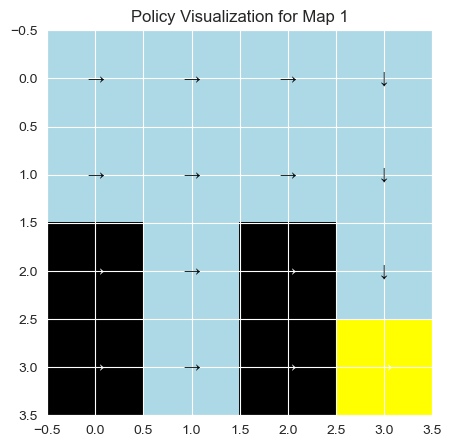

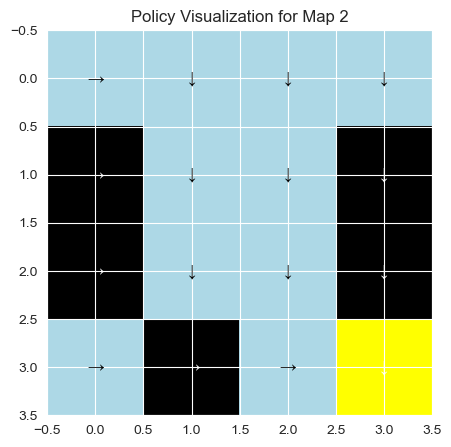

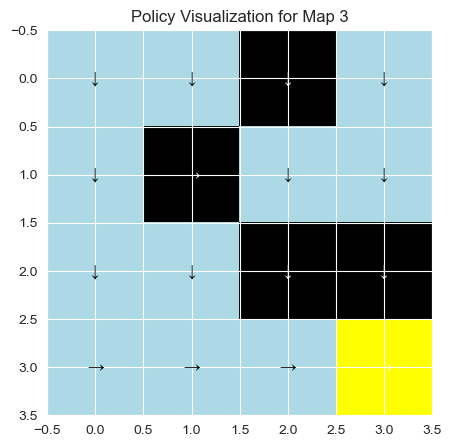

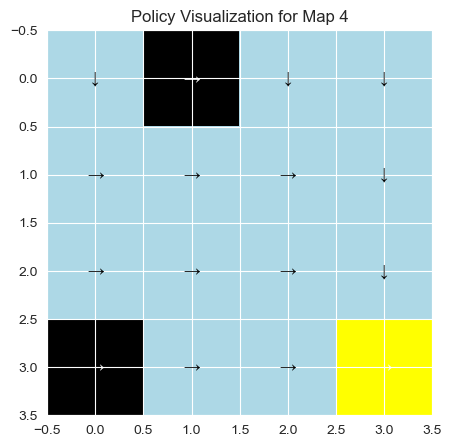

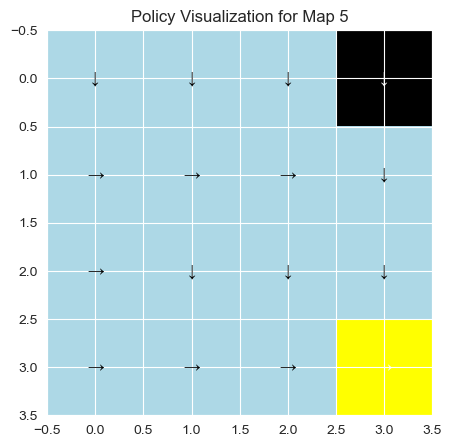

In [151]:
def visualize_policy_on_random_maps(model, device, n_maps=5, n_states=16, is_slippery=False):
    # Create a color map for the grid with your specified colors


    for map_idx in range(n_maps):
        # Create environment with a random map
        env = gym.make('FrozenLake-v1', desc=generate_random_map(size=4), is_slippery=is_slippery)

        # Convert env.desc to a string format
        desc = env.desc.astype(str)

        # Create a color map for the grid
        numerical_color_map = {'S': 2, 'F': 1, 'H': 0, 'G': 3}
        numerical_grid_colors = np.vectorize(numerical_color_map.get)(desc)


        # Extracting the policy from the model for the current map
        policy = np.array([torch.argmax(model(preprocess_state(s, env.desc).to(device))).item() for s in range(env.observation_space.n)])

        # Mapping actions to symbols for visualization
        action_symbols = {0: '←', 1: '↓', 2: '→', 3: '↑'}
        policy_symbols = np.vectorize(action_symbols.get)(policy)

        # Reshape for grid visualization
        policy_grid = policy_symbols.reshape(env.desc.shape)

        # Plotting the policy grid
        plt.figure(figsize=(5, 5))
        # Create a ListedColormap for custom colors
        cmap = ListedColormap(['black', 'lightblue', 'lightblue', 'yellow'])  # Order: H, F, S, G
        plt.imshow(numerical_grid_colors, cmap=cmap, interpolation='nearest')

        for i in range(desc.shape[0]):
            for j in range(desc.shape[1]):
                cell_color = 'white' if desc[i, j] in ['H', 'G'] else 'black'
                plt.text(j, i, policy_grid[i, j], ha='center', va='center', fontsize=12, color=cell_color)
        plt.title(f'Policy Visualization for Map {map_idx+1}')
        plt.show()

visualize_policy_on_random_maps(model, device, n_maps=5, is_slippery=False)

In [25]:
print(env.desc)


[[b'S' b'F' b'F' b'F']
 [b'F' b'H' b'F' b'H']
 [b'F' b'F' b'F' b'H']
 [b'H' b'F' b'F' b'G']]


In [21]:
def analyze_failures(env, model, num_episodes=100):
    failed_states = []
    for _ in range(num_episodes):
        state = env.reset()[0]
        done = False
        while not done:
            action = torch.argmax(model(torch.FloatTensor(np.eye(env.observation_space.n)[state]).to(device))).item()
            next_state, reward, done, _, _ = env.step(action)
            if done and reward == 0:  # Check if the episode ended without success
                failed_states.append(state)
            state = next_state
    return failed_states

# Analyze failures
failed_states = analyze_failures(env, model)
print("Failure States: ", set(failed_states))

Failure States:  {6}


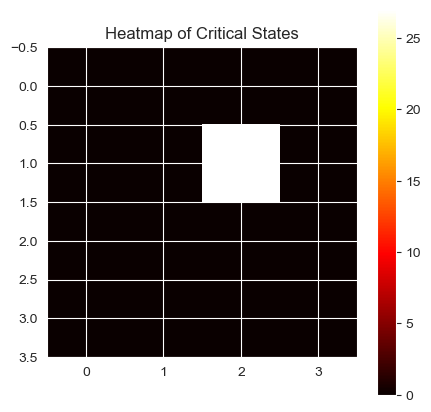

In [22]:
def plot_heatmap(env, state_counts):
    grid_counts = np.zeros(env.desc.shape)
    for state, count in state_counts.items():
        x, y = np.unravel_index(state, env.desc.shape)
        grid_counts[x, y] = count

    plt.figure(figsize=(5, 5))
    plt.imshow(grid_counts, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Heatmap of Critical States')
    plt.show()

# Count occurrences of each state in failure cases
state_counts = Counter(failed_states)

# Plot heatmap
plot_heatmap(env, state_counts)
